# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.12
anaconda-client               1.11.0
anaconda-navigator            2.3.1
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.11.7
astropy                       5.1
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
binaryornot                   0.4.4
bi

In [14]:
import tensorflow as tf
import os

In [15]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [16]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [21]:
import cv2
import imghdr

In [22]:
data_dir = 'R_NR' 

In [23]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [24]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Image not in ext list R_NR\Recyclable\README (2).txt
Image not in ext list R_NR\Recyclable\README.txt


# 3. Load Data

In [7]:
tf.data.Dataset??


Init signature: tf.data.Dataset(variant_tensor)
Source:        
@tf_export("data.Dataset", v1=[])
class DatasetV2(
    collections_abc.Iterable,
    tracking_base.Trackable,
    composite_tensor.CompositeTensor,
    metaclass=abc.ABCMeta):
  """Represents a potentially large set of elements.

  The `tf.data.Dataset` API supports writing descriptive and efficient input
  pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

  Iteration happens in a streaming fashion, so the full dataset does not need to
  fit into memory.

  Source Datasets:

  The simplest way to create a dataset is to create it from a python `list`:

  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
  >>> for element in dataset:
  ...   print(element)
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor(2, shape=(), dtype=int32)
  tf.Tensor(3, s

In [25]:
import numpy as np
from matplotlib import pyplot as plt

In [26]:
data = tf.keras.utils.image_dataset_from_directory('R_NR')

Found 11223 files belonging to 2 classes.


In [28]:
data_iterator = data.as_numpy_iterator()

In [29]:
batch = data_iterator.next()

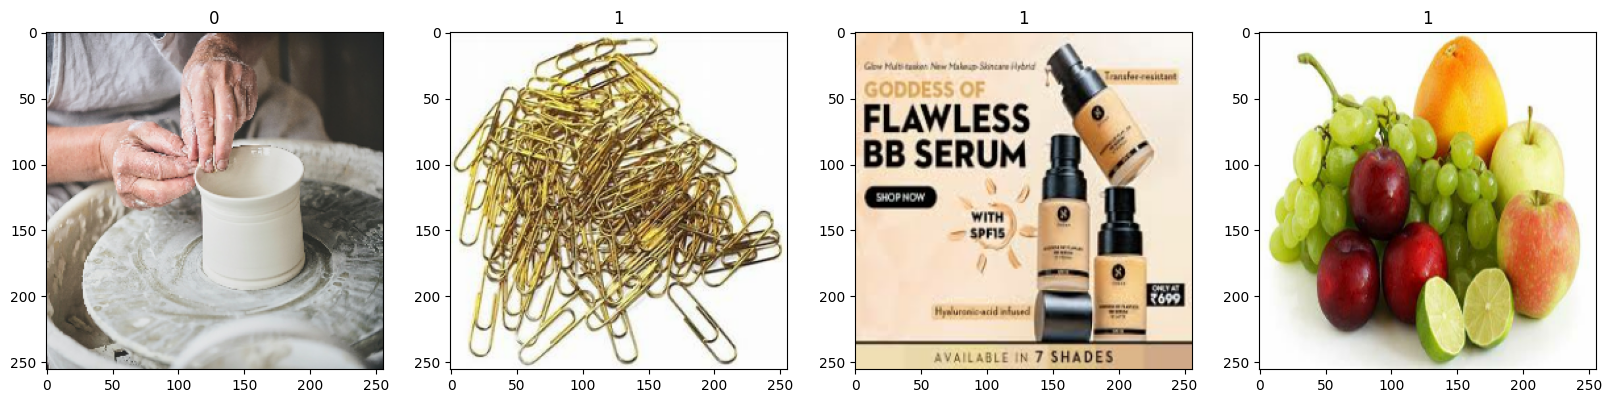

In [30]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [31]:
data = data.map(lambda x,y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [32]:
data.as_numpy_iterator().next()

(array([[[[0.85068214, 0.8882353 , 0.9205351 ],
          [0.89411765, 0.8973652 , 0.9136254 ],
          [0.8896413 , 0.89166   , 0.92817956],
          ...,
          [0.7607843 , 0.7882353 , 0.8509804 ],
          [0.7607843 , 0.7882353 , 0.8509804 ],
          [0.7607843 , 0.7882353 , 0.8509804 ]],
 
         [[0.8063275 , 0.8593075 , 0.8988583 ],
          [0.8944178 , 0.8979655 , 0.9130883 ],
          [0.8884909 , 0.8829456 , 0.9054645 ],
          ...,
          [0.7607843 , 0.79172796, 0.8439951 ],
          [0.7607843 , 0.79172796, 0.8439951 ],
          [0.7607843 , 0.79172796, 0.8439951 ]],
 
         [[0.71667004, 0.8143756 , 0.879844  ],
          [0.8543802 , 0.88718307, 0.9098145 ],
          [0.8911961 , 0.892132  , 0.906665  ],
          ...,
          [0.7666054 , 0.7979779 , 0.8411152 ],
          [0.7666054 , 0.7979779 , 0.8411152 ],
          [0.7666054 , 0.7979779 , 0.8411152 ]],
 
         ...,
 
         [[0.04941454, 0.31038266, 0.46522337],
          [0.04236

# 5. Split Data

In [33]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [34]:
train_size

245

In [35]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [36]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [38]:
model = Sequential()

In [39]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [40]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [42]:
logdir='logs'

In [43]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [44]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
245/245 [==============================] - 98s 392ms/step - loss: 0.6548 - accuracy: 0.6202 - val_loss: 0.5976 - val_accuracy: 0.6871
Epoch 2/20
245/245 [==============================] - 100s 409ms/step - loss: 0.5259 - accuracy: 0.7394 - val_loss: 0.5173 - val_accuracy: 0.7478
Epoch 3/20
245/245 [==============================] - 106s 432ms/step - loss: 0.3428 - accuracy: 0.8532 - val_loss: 0.4670 - val_accuracy: 0.7946
Epoch 4/20
245/245 [==============================] - 107s 436ms/step - loss: 0.1741 - accuracy: 0.9330 - val_loss: 0.4815 - val_accuracy: 0.8513
Epoch 5/20
245/245 [==============================] - 104s 424ms/step - loss: 0.0963 - accuracy: 0.9662 - val_loss: 0.5645 - val_accuracy: 0.8665
Epoch 6/20
245/245 [==============================] - 103s 421ms/step - loss: 0.0605 - accuracy: 0.9790 - val_loss: 0.7490 - val_accuracy: 0.8723
Epoch 7/20
245/245 [==============================] - 105s 428ms/step - loss: 0.0544 - accuracy: 0.9824 - val_loss: 0.7643 - 

# 8. Plot Performance

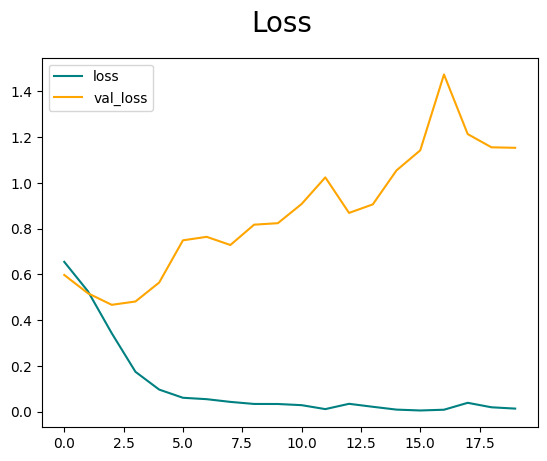

In [45]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

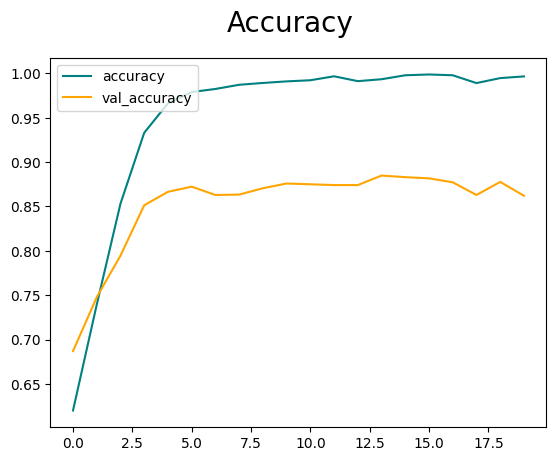

In [46]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [47]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [48]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [49]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 76ms/step


In [50]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.8844221, shape=(), dtype=float32) tf.Tensor(0.84751207, shape=(), dtype=float32) tf.Tensor(0.8535714, shape=(), dtype=float32)


# 10. Test

In [59]:
import cv2

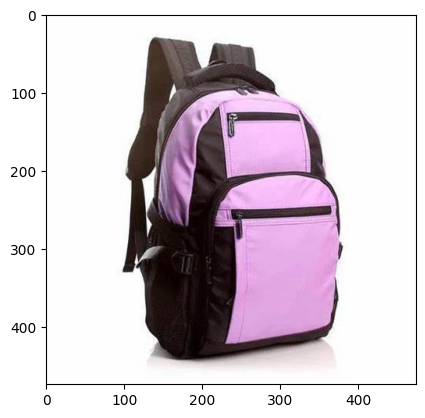

In [71]:
img = cv2.imread('bag.jpg')
plt.imshow(img)
plt.show()

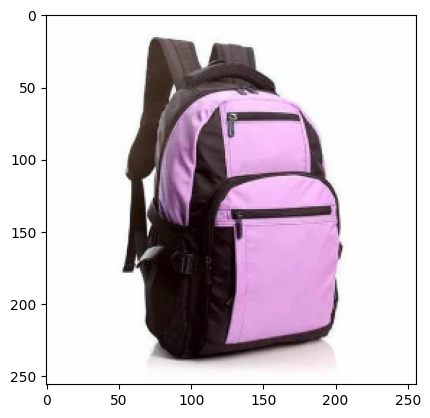

In [72]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [73]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 25ms/step


In [74]:
yhat

array([[1.]], dtype=float32)

In [75]:
if yhat > 0.5: 
    print(f'Predicted class is Recyclable')
else:
    print(f'Predicted class is Non-Recyclable')

Predicted class is Recyclable


# 11. Save the Model

In [76]:
from tensorflow.keras.models import load_model

In [77]:
model.save(os.path.join('models','R_NR_2.h5'))

In [78]:
new_model = load_model(os.path.join('models','R_NR_1.h5'))

In [79]:
yhat_new = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 59ms/step


In [80]:
if yhat_new > 0.5: 
    print(f'Predicted class is Recyclable')
else:
    print(f'Predicted class is Non-Recyclable')

Predicted class is Recyclable
